In [1]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [2]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 40.6 MB/s eta 0:00:00


In [3]:
import random
from torchvision import transforms, datasets

import os
import pickle
from scipy.spatial.distance import cdist
from scipy import ndimage
import numpy as np

import dgl
import torch
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
def sigma(dists, kth=8):
    # Get k-nearest neighbors for each node
    knns = np.partition(dists, kth, axis=-1)[:, kth::-1]

    # Compute sigma and reshape
    sigma = knns.sum(axis=1).reshape((knns.shape[0], 1))/kth
    return sigma + 1e-8 # adding epsilon to avoid zero value of sigma

def compute_adjacency_matrix_images(coord, feat, use_feat=False, kth=8):
    coord = coord.reshape(-1, 2)
    # Compute coordinate distance
    c_dist = cdist(coord, coord)
    
    if use_feat:
        # Compute feature distance
        f_dist = cdist(feat, feat)
        # Compute adjacency
        A = np.exp(- (c_dist/sigma(c_dist))**2 - (f_dist/sigma(f_dist))**2 )
    else:
        A = np.exp(- (c_dist/sigma(c_dist))**2)
        
    # Convert to symmetric matrix
    A = 0.5 * (A + A.T)
    #A = 0.5 * A * A.T
    A[np.diag_indices_from(A)] = 0
    return A

def compute_edges_list(A, kth=8+1):
    # Get k-similar neighbor indices for each node
    if 1==1:   
        num_nodes = A.shape[0]
        new_kth = num_nodes - kth
        knns = np.argpartition(A, new_kth-1, axis=-1)[:, new_kth:-1]
        knns_d = np.partition(A, new_kth-1, axis=-1)[:, new_kth:-1]
    else:
        knns = np.argpartition(A, kth, axis=-1)[:, kth::-1]
        knns_d = np.partition(A, kth, axis=-1)[:, kth::-1]
    return knns, knns_d

In [5]:
class MNISTSuperPix(torch.utils.data.Dataset):
    def __init__(self,
                 data_dir,
                 split,
                 use_mean_px=True,
                 use_coord=True,
                 use_feat_for_graph_construct=False,):

        self.split = split
        self.is_test = split.lower() in ['test', 'val']
        with open(os.path.join(data_dir, 'mnist_75sp_%s.pkl' % split), 'rb') as f:
            self.labels, self.sp_data = pickle.load(f)

        self.use_mean_px = use_mean_px
        self.use_feat_for_graph = use_feat_for_graph_construct
        self.use_coord = use_coord
        self.n_samples = len(self.labels)
        self.img_size = 28

    def precompute_graph_images(self):
        print('precompute all data for the %s set...' % self.split.upper())
        self.Adj_matrices, self.node_features, self.edges_lists = [], [], []
        for index, sample in enumerate(self.sp_data):
            mean_px, coord = sample[:2]
            coord = coord / self.img_size
            A = compute_adjacency_matrix_images(coord, mean_px, use_feat=self.use_feat_for_graph)
            edges_list, _ = compute_edges_list(A)
            N_nodes = A.shape[0]
            
            x = None
            if self.use_mean_px:
                x = mean_px.reshape(N_nodes, -1)
            if self.use_coord:
                coord = coord.reshape(N_nodes, 2)
                if self.use_mean_px:
                    x = np.concatenate((x, coord), axis=1)
                else:
                    x = coord
            if x is None:
                x = np.ones(N_nodes, 1)  # dummy features
            
            self.node_features.append(x)
            self.Adj_matrices.append(A)
            self.edges_lists.append(edges_list)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        g = dgl.DGLGraph()
        g.add_nodes(self.node_features[index].shape[0])
        g.ndata['feat'] = torch.Tensor(self.node_features[index])
        for src, dsts in enumerate(self.edges_lists[index]):
            g.add_edges(src, dsts[dsts!=src])

        return g, self.labels[index]

In [6]:
# Taking the test dataset only for sample visualization
use_feat_for_graph_construct = False
tt = time.time()
data_no_feat_knn = MNISTSuperPix("/content/gdrive/MyDrive/Colab Notebooks/superpixels", 
                             split='test', 
                             #split='train', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_no_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TEST set...
Time taken: 9.7999s


In [7]:
use_feat_for_graph_construct = True
tt = time.time()
data_with_feat_knn = MNISTSuperPix("/content/gdrive/MyDrive/Colab Notebooks/superpixels", 
                             #split='test', 
                             split='train', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_with_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TRAIN set...
Time taken: 59.8093s


100%|██████████| 9912422/9912422 [00:00<00:00, 56312837.00it/s]


Extracting PATH/MNIST/raw/train-images-idx3-ubyte.gz to PATH/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 70509717.01it/s]


Extracting PATH/MNIST/raw/train-labels-idx1-ubyte.gz to PATH/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25416633.52it/s]


Extracting PATH/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5013297.04it/s]


Extracting PATH/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH/MNIST/raw



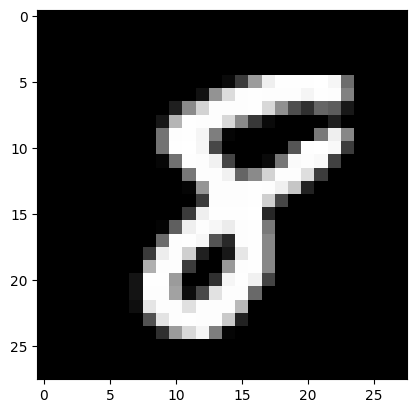

In [8]:
#dataset = datasets.MNIST(root='PATH', train=False, download=True, transform=transforms.ToTensor())
dataset = datasets.MNIST(root='PATH', train=True, download=True, transform=transforms.ToTensor())

x, _ = dataset[777] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Label:  6


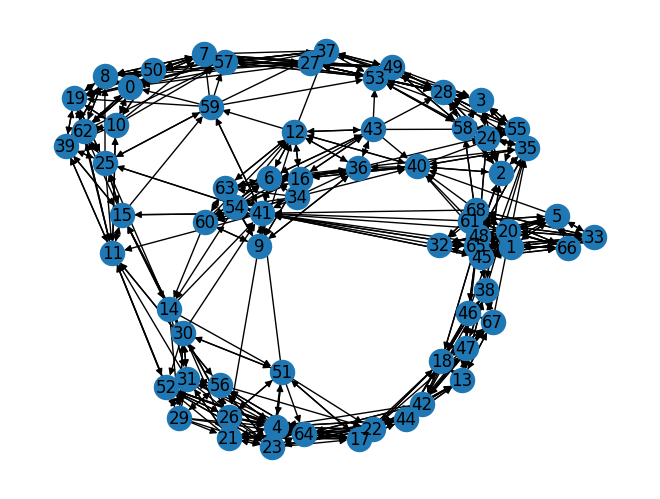

In [9]:
sample = np.random.choice(len(data_no_feat_knn))
g_sample = data_with_feat_knn[sample][0]
print("Label: ", data_no_feat_knn[sample][1])
nx.draw(g_sample.to_networkx(), with_labels=True)
plt.show()

In [10]:
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams

def plot_superpixels_graph(plt, sp_data, adj_matrix, label, feat_coord, with_edges):
    Y = squareform(pdist(sp_data[1], 'euclidean'))
    x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
    intensities = sp_data[0].reshape(-1)

    G = nx.from_numpy_array(Y)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree
    
    edge_list = []
    for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
        for dst in dsts:
            edge_list.append((src, dst))

    nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
    if with_edges:
        nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)
    title = "Label: " + str(label)
    if feat_coord:
        title += " | Using feat and coord for knn"
    else:
        title += " | Using only coord for knn"
    if not with_edges:
        title = "Label: " + str(label) + " | Only superpixel nodes"
    
    plt.title.set_text(title)
    
def show_image(plt, idx, alpha):
    x, label = dataset[idx] # x is now a torch.Tensor
    img = x.numpy()[0]
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title.set_text("Label: " + str(label) + " | Original Image")

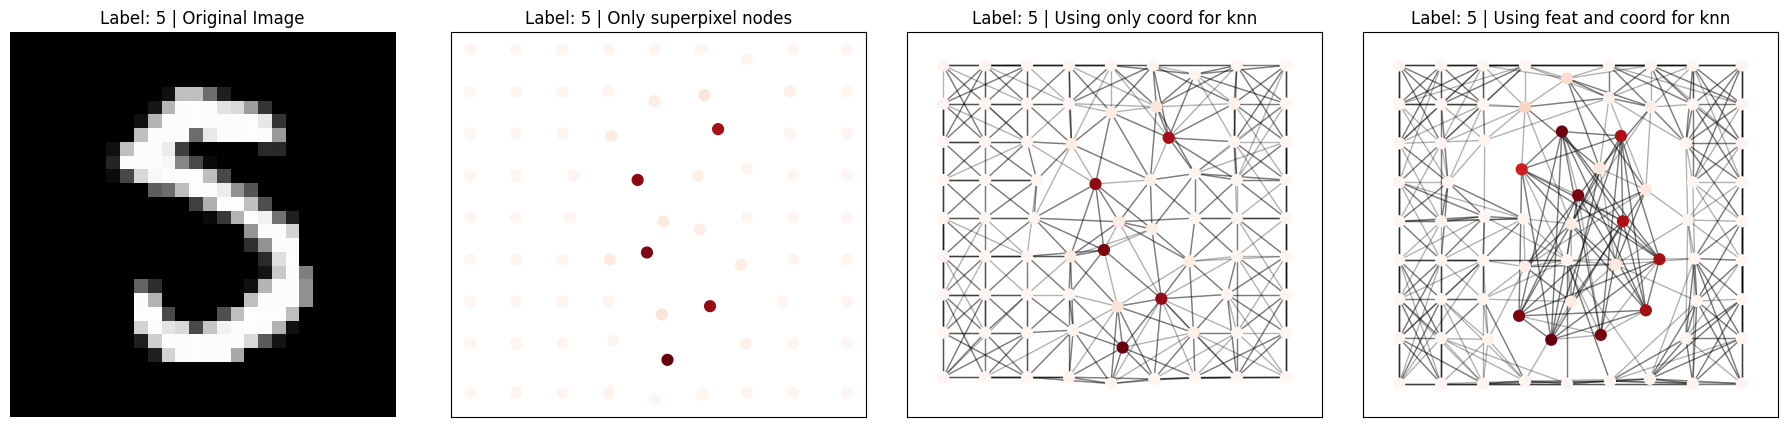

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


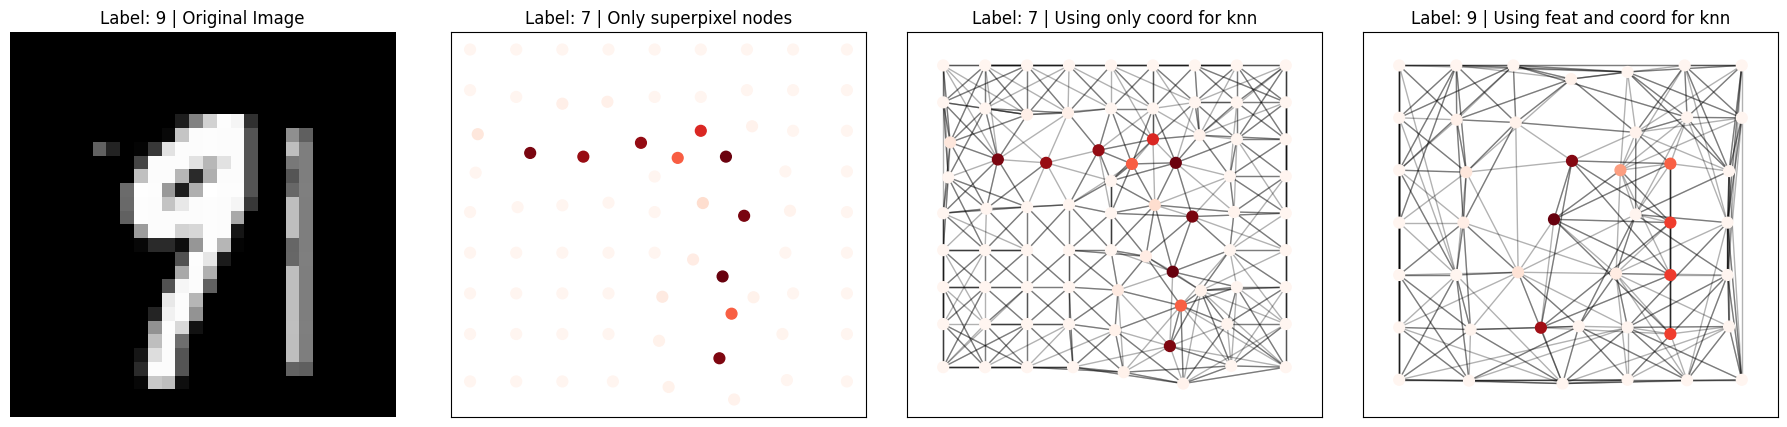

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


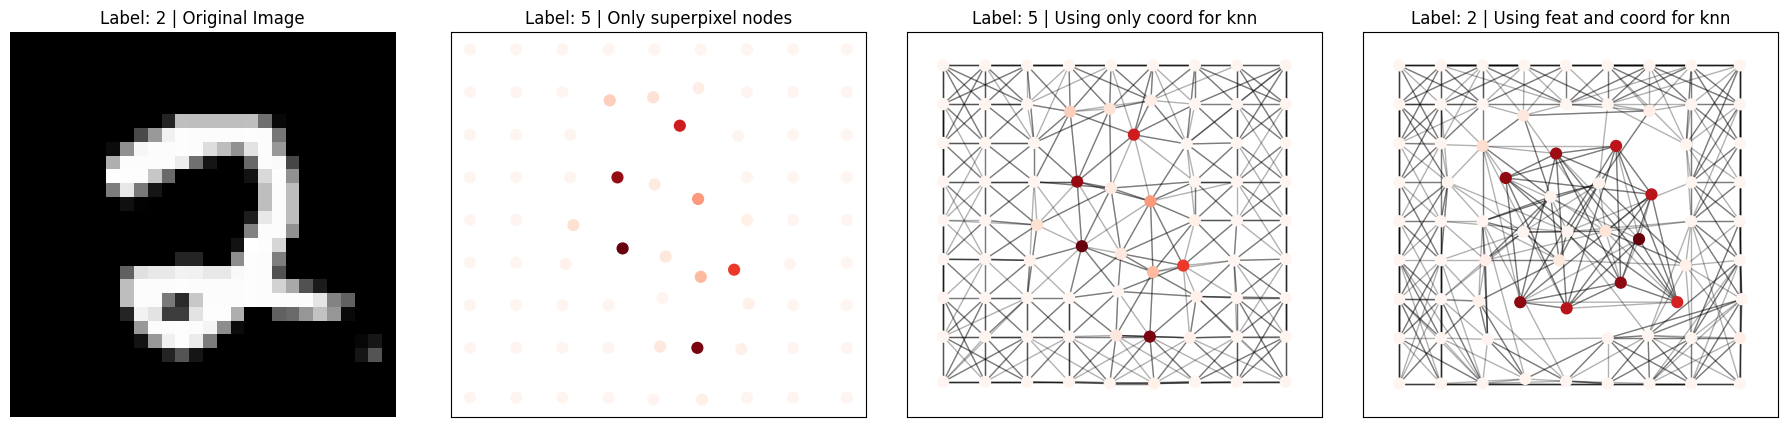

In [11]:
num_samples_plot = 3
for f_idx, idx in enumerate(np.random.choice(int(len(data_no_feat_knn)/2), num_samples_plot, replace=False)):
    f = plt.figure(f_idx, figsize=(23, 5))
    plt1 = f.add_subplot(141)
    show_image(plt1, idx, alpha=0.5)

    plt2 = f.add_subplot(142)  
    plot_superpixels_graph(plt2, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=False)

    plt3 = f.add_subplot(143)
    plot_superpixels_graph(plt3, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt4 = f.add_subplot(144)
    plot_superpixels_graph(plt4, data_with_feat_knn.sp_data[idx],
                           data_with_feat_knn.Adj_matrices[idx],
                           data_with_feat_knn[idx][1],
                           data_with_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    f.savefig('/content/gdrive/MyDrive/Colab Notebooks/superpixels/superpixels_'+str(idx)+'.jpg')
    plt.show()

In [12]:
print(compute_edges_list(data_no_feat_knn.Adj_matrices[0])[1][:10])

[[0.1045919  0.11452486 0.15301287 0.48146939 0.49390155 0.50223442
  0.31652066 0.18329217]
 [0.10975802 0.37266894 0.11878073 0.56332896 0.58437113 0.1304128
  0.34246224 0.5602831 ]
 [0.08408628 0.35871555 0.17587178 0.61200572 0.07942178 0.65114042
  0.16235309 0.34785986]
 [0.07177784 0.08216673 0.3292528  0.32776123 0.16294893 0.63533602
  0.16853781 0.63821617]
 [0.07032086 0.11683137 0.129126   0.16853781 0.33153394 0.64116038
  0.58185824 0.69771142]
 [0.1293906  0.46322533 0.13182066 0.15255453 0.47111002 0.59118566
  0.35393198 0.60737558]
 [0.14059056 0.55887104 0.44396376 0.31227914 0.24688634 0.29351904
  0.5722054  0.15206119]
 [0.13588626 0.2220294  0.25247116 0.25547382 0.82645856 0.82058738
  0.27921776 0.39528728]
 [0.14770803 0.13053675 0.22364501 0.32652554 0.82058738 0.36457436
  0.53138261 0.37627106]
 [0.14059056 0.15255453 0.211408   0.2750024  0.31796871 0.53618274
  0.61583135 0.60761752]]


In [13]:
print(compute_edges_list(data_with_feat_knn.Adj_matrices[0])[1][:10])

[[5.11170529e-01 3.33177454e-01 3.41299129e-01 8.51586803e-02
  2.86151356e-01 5.27729445e-01 5.31480419e-01 9.70618866e-02]
 [1.13101417e-04 1.84309803e-04 1.56313347e-03 8.29038701e-02
  7.31807712e-03 7.66930403e-03 1.74267837e-02 2.52777492e-01]
 [7.58031764e-02 5.90946952e-01 3.31845741e-01 1.62990428e-01
  6.35376005e-01 3.23265264e-01 1.71156842e-01 7.87975630e-02]
 [2.93434270e-03 3.88460164e-03 7.10047442e-03 7.11912787e-03
  5.94741403e-02 8.84572921e-02 4.13922762e-03 9.15331246e-03]
 [1.29912507e-02 2.69469917e-02 3.57949843e-02 6.81081627e-01
  6.75306102e-01 3.43804280e-01 5.04693038e-01 2.45410247e-01]
 [7.87975630e-02 6.42733887e-02 7.67858361e-02 1.27205879e-01
  3.01254684e-01 3.28960174e-01 5.30220763e-01 5.46779116e-01]
 [1.34098933e-18 4.56881538e-13 2.46982936e-20 8.89060839e-09
  1.29695687e-03 2.48568442e-01 1.52867868e-06 1.41522616e-06]
 [1.16330661e-04 1.26978140e-04 1.34290780e-04 2.09995735e-04
  2.54032490e-04 2.54032541e-04 2.17967996e-03 1.74267837e-02]


In [14]:
if not os.path.isfile('superpixels.zip'):
    print('downloading..')
    !curl https://www.dropbox.com/s/y2qwa77a0fxem47/superpixels.zip?dl=1 -o superpixels.zip -J -L -k
    !unzip superpixels.zip -d ../
    # !tar -xvf superpixels.zip -C ../
else:
    print('File already downloaded')

downloading..
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     61      0 --:--:-- --:--:-- --:--:--    61
100   342  100   342    0     0    526      0 --:--:-- --:--:-- --:--:--   526
100  324M  100  324M    0     0  49.9M      0  0:00:06  0:00:06 --:--:-- 66.3M
Archive:  superpixels.zip
 extracting: ../superpixels/cifar10_150sp_test.pkl  
 extracting: ../superpixels/cifar10_150sp_train.pkl  
 extracting: ../superpixels/mnist_75sp_test.pkl  
 extracting: ../superpixels/mnist_75sp_train.pkl  
